In [1]:
%load_ext autoreload
%autoreload 2


import matplotlib.pyplot as plt
import seaborn as sns


import warnings
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')
%pylab inline


%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
import tsgm

2022-06-25 18:48:47.666742: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


We want to generate a temporal dataset where each time series belongs to one of two classes. Let's go step by step through the solution.

#### 1. Define parameters of VAE:
First, we are defining the parameters of GAN, and the training algorithm.
- `latent_dim` is the size of latent representation (the output of encoder, and the input of encoder),
- `num_classes` is the number of classes, which, mentioned above is two,
- `feat_dim` is the number of time series features,
- `seq_len` is the length of the time series.

In [3]:
seq_len = 256
feat_dim = 1
num_classes = 2
latent_dim = 32

#### 2. Choose architecture.
Here, you can either use one of the architectures presented in `tsgm.models.architectures`, or define custom discriminator and generator architectures as `tf` models.

In [19]:
model_type = tsgm.models.architectures.zoo["cvae_conv5"]
architecture = model_type(seq_len=seq_len, feat_dim=feat_dim, latent_dim=latent_dim, output_dim=2)

encoder, decoder = architecture._encoder, architecture._decoder

In [20]:
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 3)]     0           []                               
                                                                                                  
 conv1d_5 (Conv1D)              (None, 256, 64)      1984        ['input_3[0][0]']                
                                                                                                  
 dropout_8 (Dropout)            (None, 256, 64)      0           ['conv1d_5[0][0]']               
                                                                                                  
 conv1d_6 (Conv1D)              (None, 256, 64)      8256        ['dropout_8[0][0]']              
                                                                                            

In [21]:
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 256, 34)]         0         
                                                                 
 conv1d_transpose_3 (Conv1DT  (None, 512, 64)          4416      
 ranspose)                                                       
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 512, 64)           0         
                                                                 
 dropout_13 (Dropout)        (None, 512, 64)           0         
                                                                 
 conv1d_transpose_4 (Conv1DT  (None, 1024, 64)         8256      
 ranspose)                                                       
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 1024, 64)          0   

#### 3. Load data:
We are working with a toy dataset, and use `tsgm` utility called `tsgm.utils.gen_sine_vs_const_dataset` to generate the data. Next, we featurewise scale the dataset so that each feature is in $[-1, 1]$, using `tsgm.utils.TSFeatureWiseScaler`.

In [22]:
X, y_i = tsgm.utils.gen_sine_vs_const_dataset(5000, 256, 1, max_value=20, const=10)

scaler = tsgm.utils.TSFeatureWiseScaler((0, 1))
X = scaler.fit_transform(X).astype(np.float32)
y = keras.utils.to_categorical(y_i, num_classes).astype(np.float32)

#### 4. Define model and train it.
We define conditional GAN model (`tsgm.models.cgan.ConditionalGAN`), compile it, and train using `.fit` model. Additionally, we use `tsgm.models.monitors.GANMonitor` to track training process.

In [23]:
encoder, decoder = architecture._encoder, architecture._decoder

#vae = cBetaVAE(encoder, decoder, latent_dim=latent_dim, temporal=False)
vae = tsgm.models.cvae.cBetaVAE(encoder, decoder, latent_dim=latent_dim, temporal=False)
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.0003,
    decay_steps=100,
    decay_rate=0.9)
optimizer = keras.optimizers.Adam(lr_schedule)
vae.compile(optimizer=keras.optimizers.Adam())

vae.fit(X, y, epochs=1, batch_size=128)

40/40 [==============================] - 69s 1s/step - loss: 1872.9926 - reconstruction_loss: 1630.1228 - kl_loss: 30.5540


In [25]:
x_decoded = vae.predict([X, y])

157/157 [==============================] - 8s 48ms/step


#### 5. Visualize the results.
For validating that VAE works, we check that original and reconstructed datasets are visually similar using `tsgm.utils.visualize_original_and_reconst_ts`.

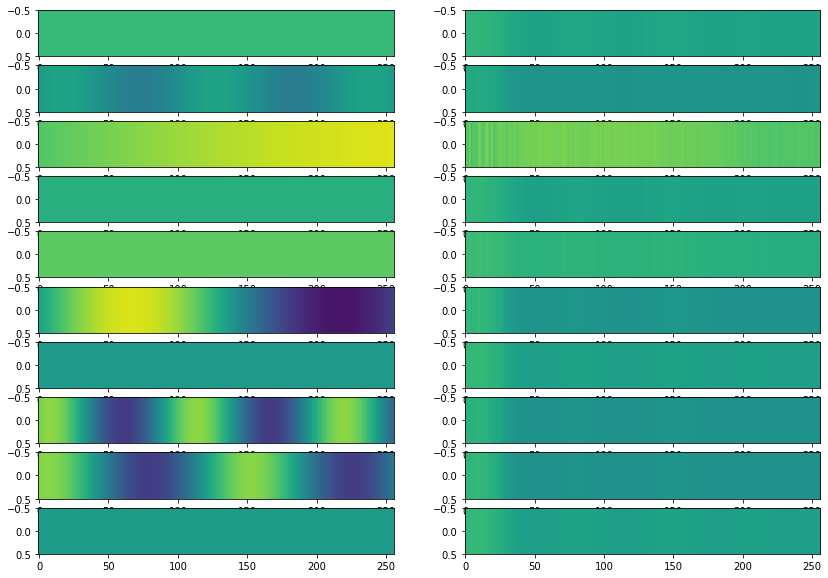

In [27]:
tsgm.utils.visualize_original_and_reconst_ts(X, x_decoded, num=10)

#### 5b Visualize via TSNE:
Now, we can generate samples from the model, and visualize them. A convinient way to visualize them is to use [t-SNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding) via `tsgm.utils.visualize_tsne`.

In [17]:
import numpy as np
from sklearn.manifold import TSNE

limit = 1000
X_sub, y_sub = X[:limit], y[:limit]
X_gen, y_gen = vae.generate(y[:limit])
X_gen = X_gen.numpy()

tsne = TSNE(n_components=2, learning_rate='auto',
                  init='random')

X_all = np.concatenate((X_sub, X_gen))
y_all = np.concatenate((y_sub, y_gen))
c = np.argmax(np.concatenate((y_sub, y_gen)), axis=1)
colors = {0: "class 0", 1: "class 1"}
c = [colors[el] for el in c]
point_styles = ["hist"] * X_sub.shape[0] + ["gen"] * X_gen.shape[0]
X_emb = tsne.fit_transform(np.resize(X_all, (X_all.shape[0], X_all.shape[1] * X_all.shape[2])))

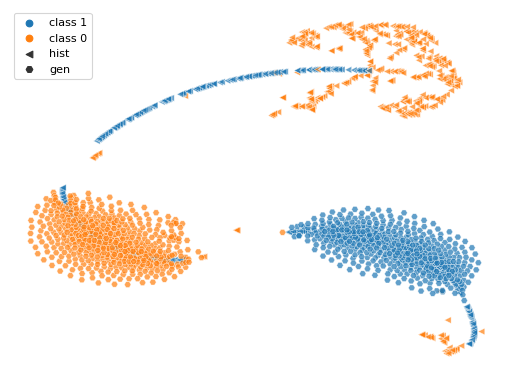

In [18]:
plt.figure(figsize=(8, 6), dpi=80)
sns.scatterplot(x=X_emb[:, 0], y=X_emb[:, 1], hue=c[:], style=point_styles[:], markers={"hist": "<", "gen": "H"}, alpha=0.7)
#sns.scatterplot(x=X_emb[limit:, 0], y=X_emb[limit:, 1], hue=c[limit:], style=point_styles[limit:], marker="s", alpha=0.5)
plt.legend()
plt.box(False)
plt.axis('off')
plt.show()